In [1]:
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from qutip import Qobj

# Core configuration & plotting settings
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qspectro2d.core.atomic_system.system_class import AtomicSystem

LaTeX: not available -> using mathtext



=== Single Atom ===
n_atoms: 1
frequencies (cm^-1): [16000.0]
dip moments: [1.0]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.        +0.j 0.        +0.j]
 [0.        +0.j 3.01391833+0.j]]
Eigenvalues (fs^-1): [0.         3.01391833]

=== Dimer (2 atoms) ===
n_atoms: 2
frequencies (cm^-1): [16500.0, 15650.0]
dip moments: [1.0, 1.2]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 2.94798886+0.j 0.01883699+0.j 0.        +0.j]
 [0.        +0.j 0.01883699+0.j 3.10810328+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 6.05609214+0.j]]
Eigenvalues (fs^-1): [0.         2.9458026  3.11028954 6.05609214]
Mixing angle theta (rad): 0.1155453335979487

=== 5-Atom Uniform Coupling ===
n_atoms: 5
frequencies (cm^-1): [16000, 16005, 16010, 16015, 16020]
dip moments: [1.0, 1.0, 1.0, 1.0, 1.0]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.        +0.j 0.        +0.j 0.        +0.j 0

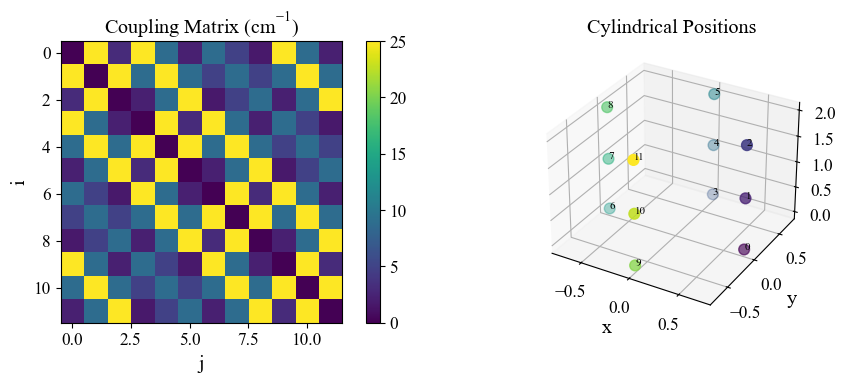

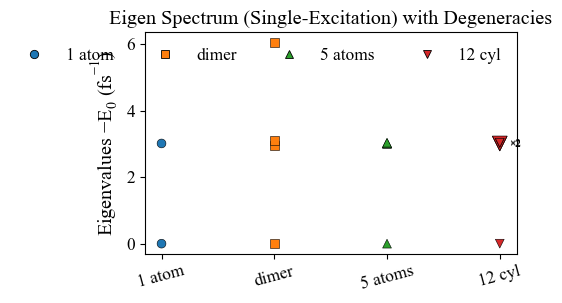

In [3]:
### Helper printing utilities
def show_basic_info(title: str, system):
    print(f"\n=== {title} ===")
    print(f"n_atoms: {system.n_atoms}")
    print("frequencies (cm^-1):", system.at_freqs_cm)
    print("dip moments:", system.dip_moments)
    if system.n_atoms <= 12:
        print("Hamiltonian matrix (fs^-1 units / ħ incorporated):")
        print(system.H0_N_canonical.full())
    print("Eigenvalues (fs^-1):", system.eigenstates[0])

### 1. Single atom system
single = AtomicSystem(n_atoms=1, at_freqs_cm=[16000.0], dip_moments=[1.0])
show_basic_info("Single Atom", single)

### 2. Dimer with coupling
# Simple two-site system with modest detuning and coupling
dimer = AtomicSystem(
    n_atoms=2,
    max_excitation=2,  # double-excitation manifold
    at_freqs_cm=[16500.0, 15650.0],
    dip_moments=[1.0, 1.2],
    at_coupling_cm=100.0,
)
show_basic_info("Dimer (2 atoms)", dimer)
print("Mixing angle theta (rad):", dimer.theta)

### 3. 5-atom system (single-excitation manifold) with uniform coupling
multi_uniform = AtomicSystem(
    n_atoms=5,
    at_freqs_cm=[16000 + 5*i for i in range(5)],
    dip_moments=[1.0]*5,
    at_coupling_cm=30.0,
)
show_basic_info("5-Atom Uniform Coupling", multi_uniform)

### 4. 12-atom cylindrical geometry (2 chains x 3 rings) with 1/r^3 couplings
cyl = AtomicSystem(
    n_atoms=12,
    n_rings=3,  # 3 rings, 2 chains
    at_freqs_cm=[16000.0]*12,
    dip_moments=[1.0]*12,
    at_coupling_cm=20.0,  # used as default prefactor if not specified
)
# Place on cylinder and build couplings
cyl.set_cylindrical_geometry(distance=1.0, build_couplings=True, coupling_prefactor_cm=25.0)
show_basic_info("Cylindrical Geometry (12 atoms)", cyl)
print("Positions (arbitrary units):\n", cyl.positions)
print("Coupling matrix (cm^-1):\n", cyl.coupling_matrix_cm)

### Visualization: Coupling matrix heatmap & 3D positions
fig = plt.figure(figsize=(12,4))

# Coupling matrix heatmap
ax1 = fig.add_subplot(1,2,1)
mat = cyl.coupling_matrix_cm
im = ax1.imshow(mat, cmap='viridis')
ax1.set_title("Coupling Matrix (cm$^{-1}$)")
ax1.set_xlabel("j")
ax1.set_ylabel("i")
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# 3D positions
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
ax2 = fig.add_subplot(1,2,2, projection='3d')
pos = cyl.positions
ax2.scatter(pos[:,0], pos[:,1], pos[:,2], c=np.arange(len(pos)), cmap='viridis', s=60)
for idx, (x,y,z) in enumerate(pos):
    ax2.text(x, y, z, f"{idx}", fontsize=8)
ax2.set_title("Cylindrical Positions")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.tight_layout()
plt.show()

### 5. Energy spectrum comparison plot (eigenvalues with degeneracy)
# =============================
# DEGENERACY-AWARE PLOT (auto-configured: no manual systems/labels/colors lists)
# =============================
# Assemble systems in an ordered mapping for automatic iteration
systems_map = {
    "1 atom": single,
    "dimer": dimer,
    "5 atoms": multi_uniform,
    "12 cyl": cyl,
}

# Pull color & marker cycles from global plotting settings
color_keys   = list(COLORS.keys())  # e.g. ['C0','C1',...]
marker_cycle = MARKERS              # defined in mpl_tex_settings

# Group nearly-equal eigenvalues (degeneracy) helper
def group_levels(evals: np.ndarray, atol: float = 1e-10):
    vals_sorted = np.sort(evals)
    uniq = []
    counts = []
    for e in vals_sorted:
        if not uniq or abs(e - uniq[-1]) > atol:
            uniq.append(e)
            counts.append(1)
        else:
            counts[-1] += 1
    return np.array(uniq), np.array(counts)

fig_w, fig_h = set_size(width_pt=LATEX_DOC_WIDTH, fraction=0.85, subplots=(1,1))
plt.figure(figsize=(fig_w, fig_h))

handles = []
for x, (label, sys) in enumerate(systems_map.items()):
    evals = sys.eigenstates[0]
    evals_shift = evals - evals.min()  # shift so ground level = 0
    uniq, counts = group_levels(evals_shift)

    color_key = color_keys[x % len(color_keys)]
    color     = COLORS[color_key]
    marker    = marker_cycle[x % len(marker_cycle)]

    # Marker size encodes degeneracy
    sizes = 40 + 70*(counts-1)  # base size + additive per extra state
    plt.scatter(
        np.full_like(uniq, x, dtype=float),
        uniq,
        s=sizes,
        color=color,
        marker=marker,
        edgecolors='k',
        linewidths=0.4,
        label=label,
        zorder=3,
    )

    # Annotate degeneracy if >1; small horizontal jitter for readability
    for u, cnt in zip(uniq, counts):
        if cnt > 1:
            plt.text(x + 0.08, u, f"×{cnt}", va='center', ha='left', fontsize=8)

    # Build legend handle (single unified per system)
    handles.append(
        plt.Line2D(
            [0],[0],
            marker=marker,
            color='none',
            markerfacecolor=color,
            markeredgecolor='k',
            markeredgewidth=0.6,
            markersize=6,
            label=label,
        )
    )

plt.ylabel(r'Eigenvalues $- E_0$ (fs$^{-1}$)')
plt.xticks(range(len(systems_map)), list(systems_map.keys()), rotation=15)
plt.title('Eigen Spectrum (Single-Excitation) with Degeneracies')
plt.grid(False)
plt.legend(handles=handles, frameon=False, ncol=len(systems_map))
plt.tight_layout()
plt.show()